In [282]:
%env CUDA_VISIBLE_DEVICES=-1
%load_ext autoreload
%autoreload 2
from plot_utils import *
import sys
import os
from PIL import Image
import itertools

env: CUDA_VISIBLE_DEVICES=-1
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [283]:
datasets = ["bicycle","bonsai"]
eval_paths = {}
for exp in os.listdir("../output"):
        eval_paths[exp] = {"no compression" : {}, "mini_s" : {}, "c3dgs" : {}, "light_prune_0.66_1_0.1_v_important_score" : {}, "light_prune_0.66_1_0.1_v_important_score_distill" : {}, "light_prune_0.66_1_0.1_v_important_score_distill_vq" : {}}

        for ds in datasets:
            p = os.path.join("../output",exp,ds,"test","ours_30000")
            if os.path.exists(p):
                eval_paths[exp]["no compression"][ds] = p
            
            p_mini = os.path.join("../output",exp,"mini_s",ds,"test","ours_30000")
            if os.path.exists(p_mini):
                eval_paths[exp]["mini_s"][ds] = p_mini

            p_c3dgs = os.path.join("../output",exp,"c3dgs",ds,"test","ours_35000")
            if os.path.exists(p_c3dgs):
                eval_paths[exp]["c3dgs"][ds] = p_c3dgs

            p_lightprune = os.path.join("../output",exp,"light_prune_0.66_1_0.1_v_important_score",ds,"test","ours_5000")
            if os.path.exists(p_lightprune):
                eval_paths[exp]["light_prune_0.66_1_0.1_v_important_score"][ds] = p_lightprune

            p_lightprunedistill = os.path.join("../output",exp,"light_prune_0.66_1_0.1_v_important_score_distill",ds,"test","ours_10000")
            if os.path.exists(p_lightprune):
                eval_paths[exp]["light_prune_0.66_1_0.1_v_important_score_distill"][ds] = p_lightprunedistill

            p_lightprunedistillvq = os.path.join("../output",exp,"light_prune_0.66_1_0.1_v_important_score_distill_vq",ds,"test","ours_None")
            if os.path.exists(p_lightprune):
                eval_paths[exp]["light_prune_0.66_1_0.1_v_important_score_distill_vq"][ds] = p_lightprunedistillvq

eval_paths = transform_keys(eval_paths,{"light_prune_0.66_1_0.1_v_important_score" : "light prune","light_prune_0.66_1_0.1_v_important_score_distill" : "light prune +distill","light_prune_0.66_1_0.1_v_important_score_distill_vq" : "light prune + distill + vq",
                                        "mini_compact3d" : "mini + compact3d", "compact3d" : "compact3d", "mini_opacity" : "mini + opacity reg.", "orig_depth_reg" : "orig + depth reg.", "orig_opacity" : "orig + opacity reg." })
stats = load_stats(eval_paths)
normalized_stats,min_max = normalize_stats(stats,datasets)

In [284]:
get_storage(stats,eval_paths)

In [285]:
print(eval_paths["mini + compact3d"])

{'no compression': {'bicycle': '../output/mini_compact3d/bicycle/test/ours_30000', 'bonsai': '../output/mini_compact3d/bonsai/test/ours_30000'}, 'mini_s': {'bicycle': '../output/mini_compact3d/mini_s/bicycle/test/ours_30000', 'bonsai': '../output/mini_compact3d/mini_s/bonsai/test/ours_30000'}, 'c3dgs': {'bicycle': '../output/mini_compact3d/c3dgs/bicycle/test/ours_35000', 'bonsai': '../output/mini_compact3d/c3dgs/bonsai/test/ours_35000'}, 'light prune': {}, 'light prune +distill': {}, 'light prune + distill + vq': {}}


In [286]:
eval_paths["mini + compact3d"]

{'no compression': {'bicycle': '../output/mini_compact3d/bicycle/test/ours_30000',
  'bonsai': '../output/mini_compact3d/bonsai/test/ours_30000'},
 'mini_s': {'bicycle': '../output/mini_compact3d/mini_s/bicycle/test/ours_30000',
  'bonsai': '../output/mini_compact3d/mini_s/bonsai/test/ours_30000'},
 'c3dgs': {'bicycle': '../output/mini_compact3d/c3dgs/bicycle/test/ours_35000',
  'bonsai': '../output/mini_compact3d/c3dgs/bonsai/test/ours_35000'},
 'light prune': {},
 'light prune +distill': {},
 'light prune + distill + vq': {}}

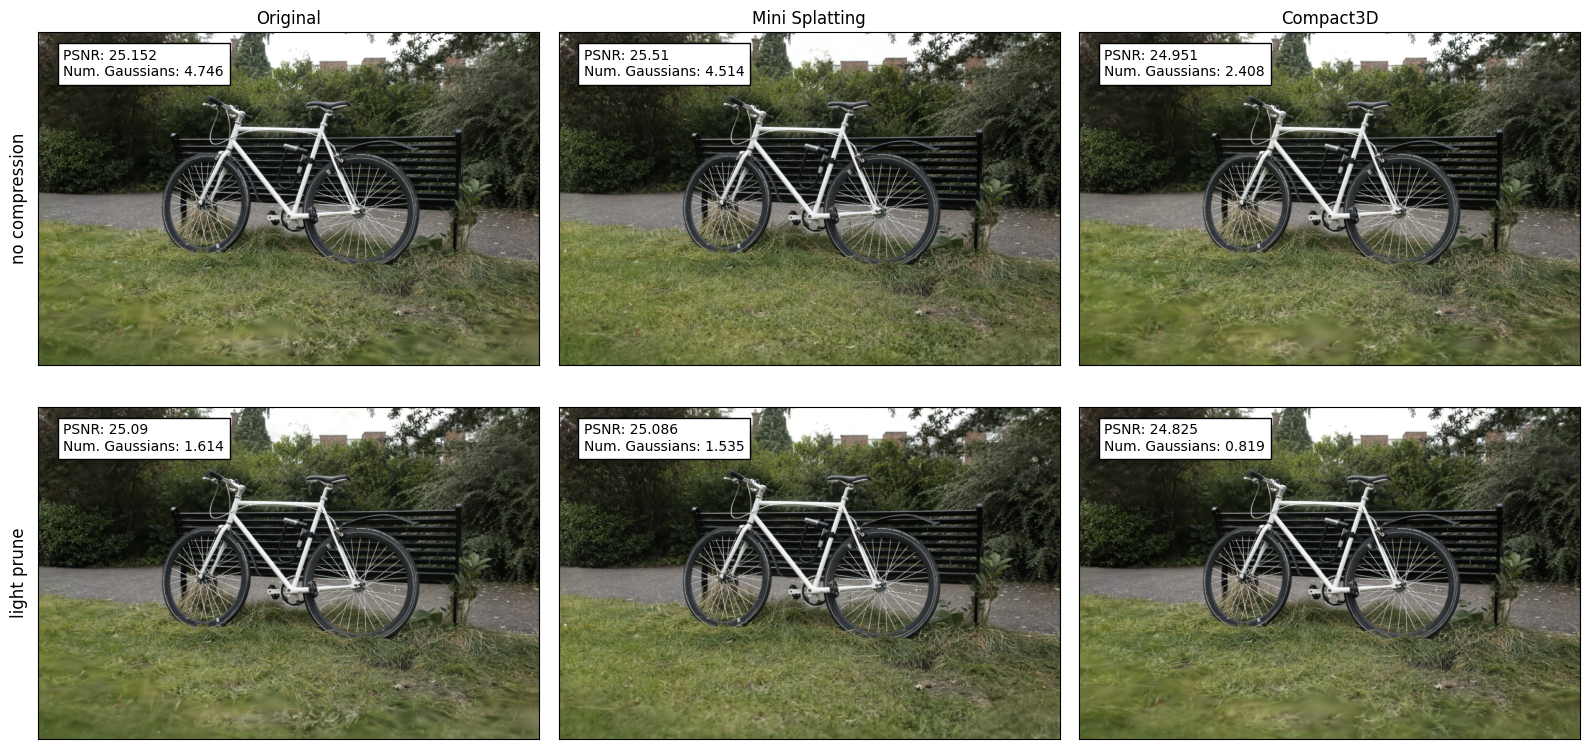

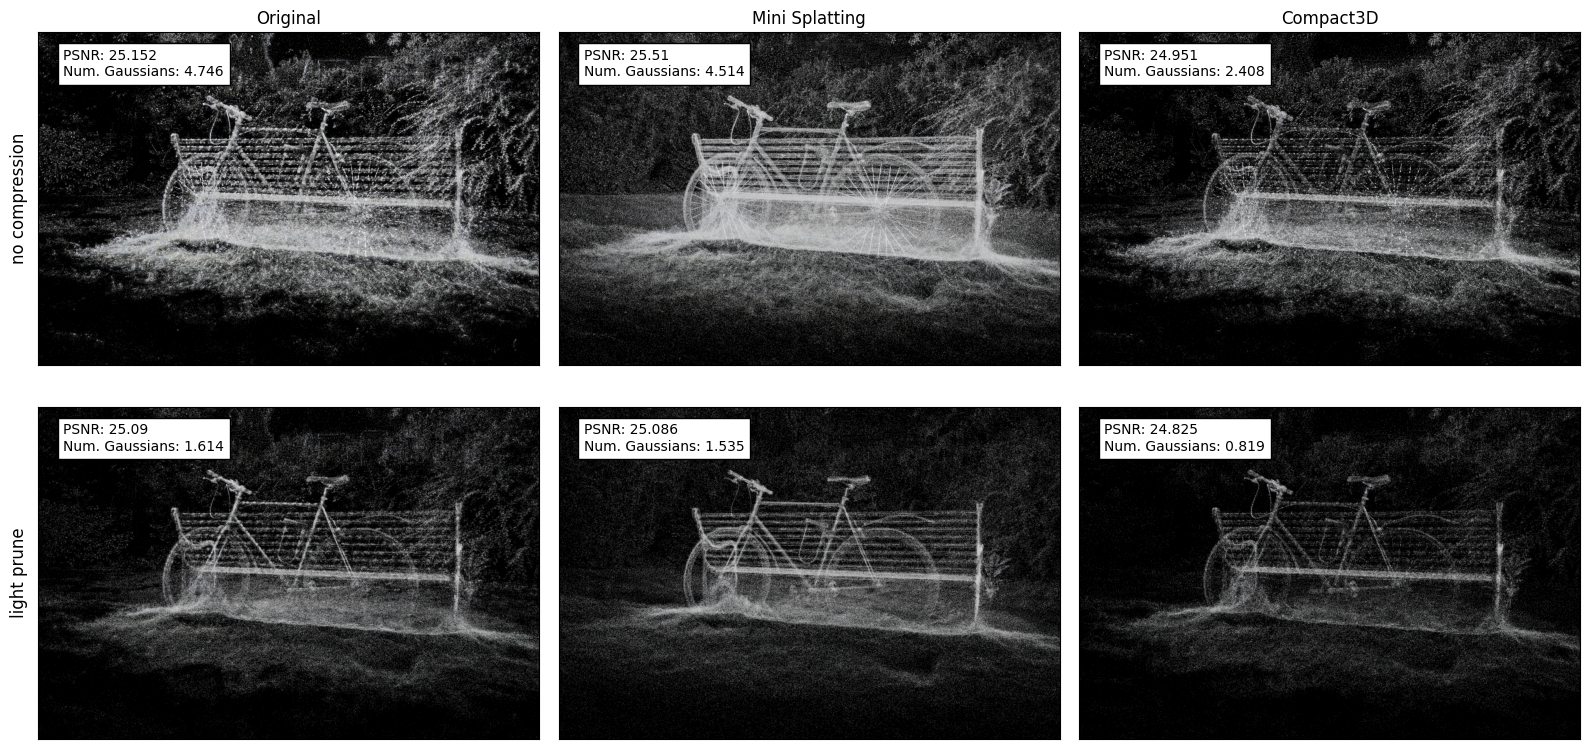

In [287]:
# Plot the density (where are gaussians where not) for a specific image from the bicycle dataset for Original,Mini Splatting and Compact3D
for render in ["renders","density"]:
    fig,axs = plt.subplots(2,3)
    remove_ticks = lambda *axs : [(ax.set_xticks([]),ax.set_xticklabels([]),ax.set_yticks([]),ax.set_yticklabels([])) for ax in axs]

    for x,comp in enumerate(["no compression", "light prune"]):
        for y,exp in enumerate(["orig","mini","compact3d"]):
            axs[x][y].imshow(Image.open(os.path.join(eval_paths[exp][comp]["bicycle"],render,"00000.png")))
            psnr = round(stats[exp][comp]["bicycle"]["psnr"],3)
            num_gauss = round(stats[exp][comp]["bicycle"]["num_gaussians"]/1e6,3)
            axs[x][y].text(0.05, 0.95, f"PSNR: {psnr} \nNum. Gaussians: {num_gauss}", transform=axs[x][y].transAxes, fontsize=10,verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

        axs[x][0].set_ylabel(comp,fontsize=12)
    remove_ticks(*[ax for ax in axs.flatten()])

    axs[0][0].set_title("Original")
    axs[0][1].set_title("Mini Splatting")
    axs[0][2].set_title("Compact3D")

   


    fig.set_size_inches(16,8)
    fig.tight_layout()
    plt.show()

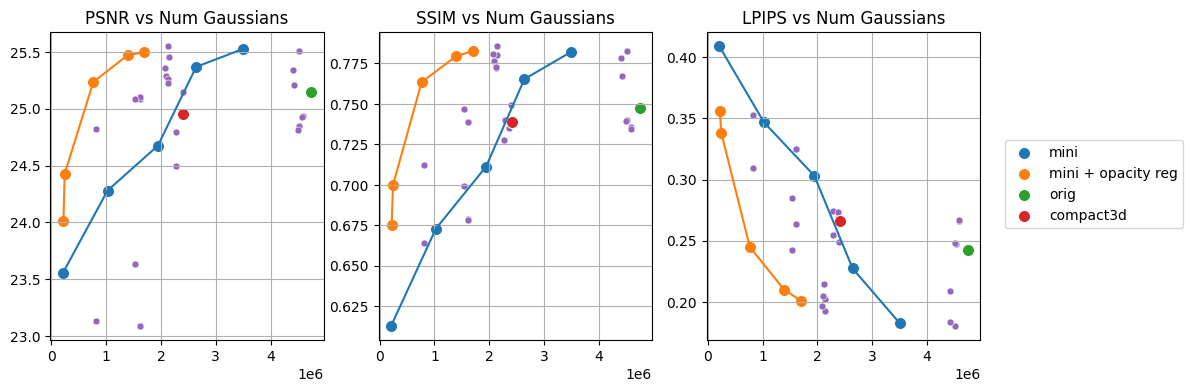

In [305]:
# Plot (PSNT,SSIM,LPIPS) vs num Gaussians for the bicycle dataset
fig,axs = plt.subplots(1,3)
colors = list(sns.color_palette())
for x,y in enumerate(["psnr","ssim","lpips"]):

    for exp in ["orig","orig + depth reg.","orig + opacity reg.","compact3d","mini","mini + compact3d","mini + opacity reg."]:
        for comp in ["no compression","mini_s","c3dgs","light prune", "light prune + distill + vq"]:
            if "bicycle" in stats[exp][comp]:
                sns.scatterplot(x=[stats[exp][comp]["bicycle"]["num_gaussians"]],y=[stats[exp][comp]["bicycle"][y]],ax=axs[x],s=25,color=colors[4])

    sns.scatterplot(x=[stats[f"mini_{i}"]["no compression"]["bicycle"]["num_gaussians"] for i in [1,3,5,7,8]],y=[stats[f"mini_{i}"]["no compression"]["bicycle"][y] for i in [1,3,5,7,8]],color=colors[0],ax=axs[x],s=75,label="mini")
    sns.lineplot(x=[stats[f"mini_{i}"]["no compression"]["bicycle"]["num_gaussians"] for i in [1,3,5,7,8]],y=[stats[f"mini_{i}"]["no compression"]["bicycle"][y] for i in [1,3,5,7,8]],color=colors[0],ax=axs[x])

    sns.scatterplot(x=[stats[f"mini_opacity_{i}"]["no compression"]["bicycle"]["num_gaussians"] for i in [1,2,5,6,7]],y=[stats[f"mini_opacity_{i}"]["no compression"]["bicycle"][y] for i in [1,2,5,6,7]],color=colors[1],ax=axs[x],s=75,label="mini + opacity reg")
    sns.lineplot(x=[stats[f"mini_opacity_{i}"]["no compression"]["bicycle"]["num_gaussians"] for i in [1,2,5,6,7]],y=[stats[f"mini_opacity_{i}"]["no compression"]["bicycle"][y] for i in [1,2,5,6,7]],color=colors[1],ax=axs[x])
    
    sns.scatterplot(x=[stats[f"orig"]["no compression"]["bicycle"]["num_gaussians"]],y=[stats[f"orig"]["no compression"]["bicycle"][y]],ax=axs[x],s=75,color=colors[2],label="orig")
    sns.scatterplot(x=[stats[f"compact3d"]["no compression"]["bicycle"]["num_gaussians"]],y=[stats[f"compact3d"]["no compression"]["bicycle"][y]],ax=axs[x],s=75,color=colors[3],label="compact3d")

    axs[x].grid(True)
    axs[x].get_legend().remove()

axs[0].set_title("PSNR vs Num Gaussians")
axs[1].set_title("SSIM vs Num Gaussians")
axs[2].set_title("LPIPS vs Num Gaussians")

handles, labels = axs[0].get_legend_handles_labels()

fig.legend(handles,labels,loc='center right',ncol=1,frameon=True,bbox_to_anchor=(1.075, 0.5),)

fig.set_size_inches(12,4)

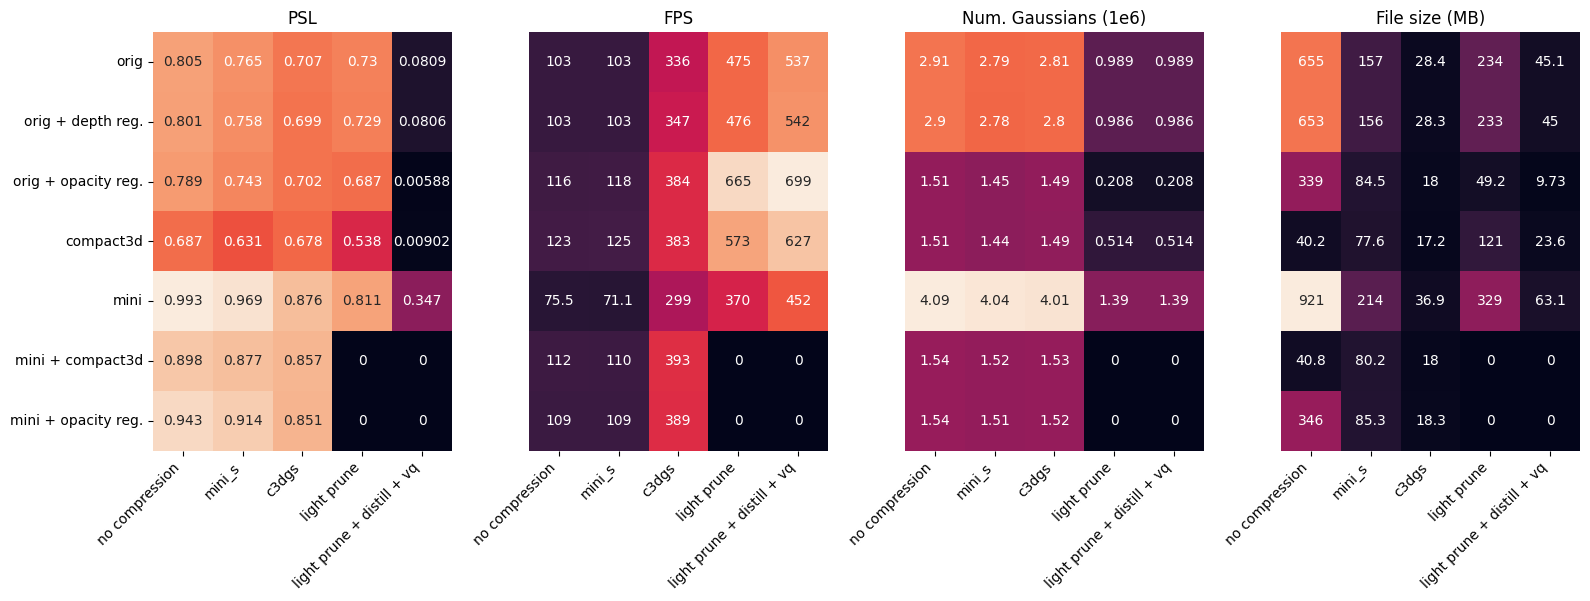

In [289]:
exps = ["orig","orig + depth reg.","orig + opacity reg.","compact3d","mini","mini + compact3d","mini + opacity reg."]
compressions = ["no compression","mini_s","c3dgs","light prune", "light prune + distill + vq"]
vslabels = ["psl","fps","num_gaussians","size"]
table_stats = copy.deepcopy(stats)
table_stats = {key : {comp_key : comp_val for comp_key,comp_val in val.items() if comp_key in compressions} for key,val in table_stats.items() if key in exps}
table_stats_normalized,table_min_max = normalize_stats(table_stats,datasets)
merge_psnr_ssim_lpips(table_stats_normalized)

fig,axs = plt.subplots(1,len(vslabels),sharex=True)
axs = axs[None,:]
for x,y in enumerate(vslabels):
    data = np.zeros((len(exps),len(compressions)))
    ratio = np.zeros((len(exps),len(compressions)))
    norm = np.zeros_like(data)
    for dx,exp in enumerate(exps):
        for dy,compression in enumerate(compressions):
            for ds in datasets:
                if y == "psl":
                    tbst = table_stats_normalized
                else:
                    tbst = table_stats
                if compression in tbst[exp].keys():
                    if ds in tbst[exp][compression].keys():
                        if y in tbst[exp][compression][ds].keys():
                            data[dx,dy] += tbst[exp][compression][ds][y]
                            norm[dx,dy] += 1
    
    
    norm = np.where(norm == 0, 1, norm)
    data = data/norm
        
    if y == "num_gaussians":
        data /= 1e6

    if x == 0:
        sns.heatmap(data,ax=axs[0][x],yticklabels=exps,xticklabels=compressions,cbar=False,annot=True,square=True,fmt='.3g')
    else:
        sns.heatmap(data,ax=axs[0][x],yticklabels=[],xticklabels=compressions,cbar=False,annot=True,square=True,fmt='.3g')

    axs[0][x].set_xticklabels(axs[0][x].get_xticklabels(),rotation=45,ha="right")
    #axs[0][x].tick_params("x", rotation=70,ha="right")

axs[0][0].set_title("PSL")
axs[0][1].set_title("FPS")
axs[0][2].set_title("Num. Gaussians (1e6)")
axs[0][3].set_title("File size (MB)")

fig.set_size_inches(16,16)
fig.tight_layout()

/home/miri/miniconda3/envs/gaussian_splatting/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice.
/home/miri/miniconda3/envs/gaussian_splatting/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


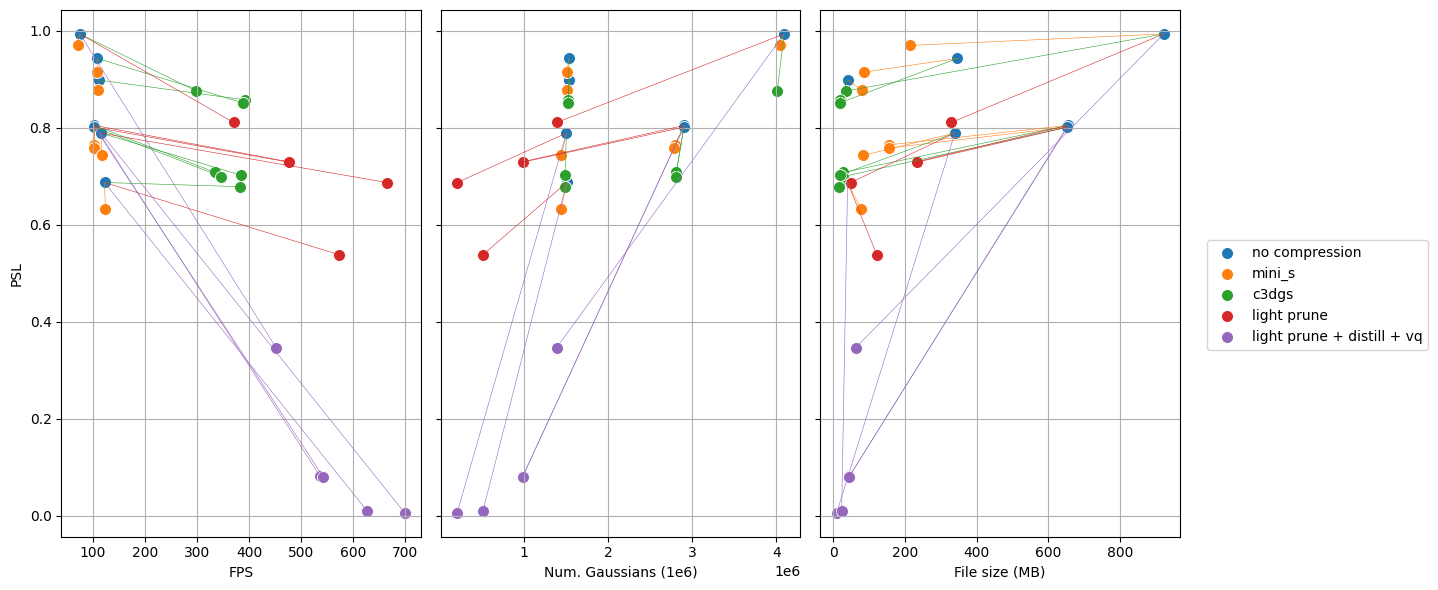

In [290]:
exps = ["orig","orig + depth reg.","orig + opacity reg.","compact3d","mini","mini + compact3d","mini + opacity reg."]
compressions = ["no compression", "mini_s","c3dgs","light prune", "light prune + distill + vq"]
vslabels = ["psl","fps","num_gaussians","size"]
fig,axs = plt.subplots(1,len(vslabels)-1,sharey="all")
axs = axs[None,:]
colors = list(sns.color_palette())

data = {comp : {vslabel : {} for vslabel in vslabels} for comp in compressions}
for dy,compression in enumerate(compressions):
    for x,y in enumerate(vslabels):
        for dx,exp in enumerate(exps):
            data_alloc = []
            for ds in datasets:
                if y == "psl":
                    tbst = table_stats_normalized
                else:
                    tbst = table_stats
                if compression in tbst[exp].keys():
                    if ds in tbst[exp][compression].keys():
                        if y in tbst[exp][compression][ds].keys():
                            data_alloc.append(tbst[exp][compression][ds][y])
                            
            data_alloc = np.asarray(data_alloc).mean()
            data[compression][y][exp] = data_alloc

for k,vslabel in enumerate(vslabels[1:]):
    for i,comp in enumerate(compressions):
        x_data = [data[comp][vslabel][exp] for exp in exps]
        y_data = [data[comp]["psl"][exp] for exp in exps]
        
        if comp != "orig":
            x_data_orig = [data["no compression"][vslabel][exp] for exp in exps]
            y_data_orig = [data["no compression"]["psl"][exp] for exp in exps]
            for (x1,y1,x2,y2) in zip(x_data,y_data,x_data_orig,y_data_orig):
                sns.lineplot(x=[x1,x2],y=[y1,y2],ax=axs[0][k],color=colors[i],linewidth=0.4)
        
        sns.scatterplot(x=x_data,y=y_data,ax=axs[0][k],s=75,color=colors[i],label=comp)

handles, labels = axs[0][0].get_legend_handles_labels()

fig.legend(handles,labels,loc='center right',ncol=1,frameon=True,bbox_to_anchor=(1.2, 0.5),)

axs[0,0].grid(True),axs[0,1].grid(True),axs[0,2].grid(True)
axs[0,0].get_legend().remove(),axs[0,1].get_legend().remove(),axs[0,2].get_legend().remove()

axs[0,0].set_ylabel("PSL")
axs[0,0].set_xlabel("FPS")
axs[0,1].set_xlabel("Num. Gaussians (1e6)")
axs[0,2].set_xlabel("File size (MB)")

fig.set_size_inches(12,6)
fig.tight_layout()
